## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [145]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

small_img_size = 14 # pix
division_shape = (2, 2) # форма разбиения изображений по вертикали и горизонтали для расчета HOG

# Общее число столбцов в гистограмме ориентированных градиентов
N_bins = 12
# N_bins = N_bins // (division_shape[0]*division_shape[1])

## Загружаем исходные данные

In [146]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [147]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
train = train[:,1:]
print(train_label[:5])
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train, (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

[1. 0. 1. 4. 0.]


## Визуализируем исходные данные

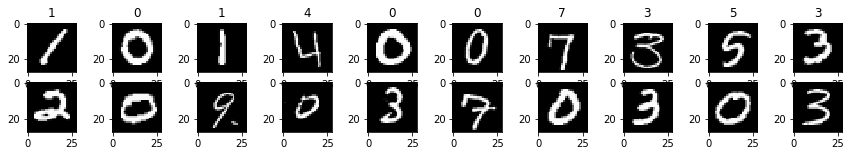

In [148]:
fig = plt.figure(figsize=(15, 2))
for i, img in enumerate(train_img[:10], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % int(train_label[i - 1]))
    subplot = fig.add_subplot(2, 10, i+10)
    plt.imshow(test_img[i-1], cmap='gray');

## Обрезаем фон, уменьшаем размерность

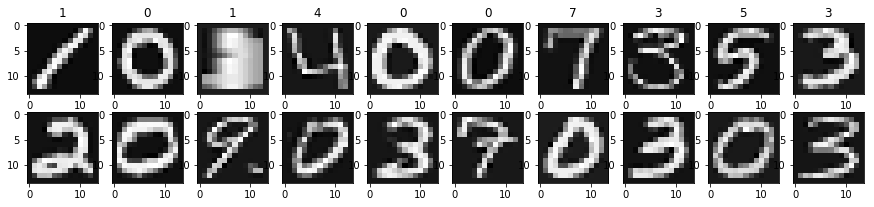

In [149]:
train_img_small = np.zeros( (train_img.shape[0], small_img_size, small_img_size) )
for i, img in enumerate(train_img):
    temp = img[img.sum(axis=1) != 0,:]
    temp = temp[:,temp.sum(axis=0) != 0]
    train_img_small[i][1:-1,1:-1] = cv2.resize(temp, dsize=(small_img_size-2,small_img_size-2),
                                               interpolation=cv2.INTER_CUBIC)

test_img_small = np.zeros( (test_img.shape[0], small_img_size, small_img_size) )
for i, img in enumerate(test_img):
    temp = img[img.sum(axis=1) != 0,:]
    temp = temp[:,temp.sum(axis=0) != 0]
    test_img_small[i][1:-1,1:-1] = cv2.resize(temp, dsize=(small_img_size-2,small_img_size-2),
                                              interpolation=cv2.INTER_CUBIC)

fig = plt.figure(figsize=(15, 3))
for i, img in enumerate(train_img_small[:10],1):
    subplot = fig.add_subplot(2, 10, i)
    subplot.set_title('{}'.format(int(train_label[i-1])));
    plt.imshow(img, cmap='gray')
    subplot = fig.add_subplot(2, 10, i+10)
    plt.imshow(test_img_small[i-1], cmap='gray')
plt.show()

In [150]:
# Переходим к рассмотрению малых обрезанных изображений
train_img = train_img_small
train = train_img[:,1:-1,1:-1].reshape(-1, (small_img_size-2)*(small_img_size-2))
test_img = test_img_small
test = test_img[:,1:-1,1:-1].reshape(-1, (small_img_size-2)*(small_img_size-2))

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

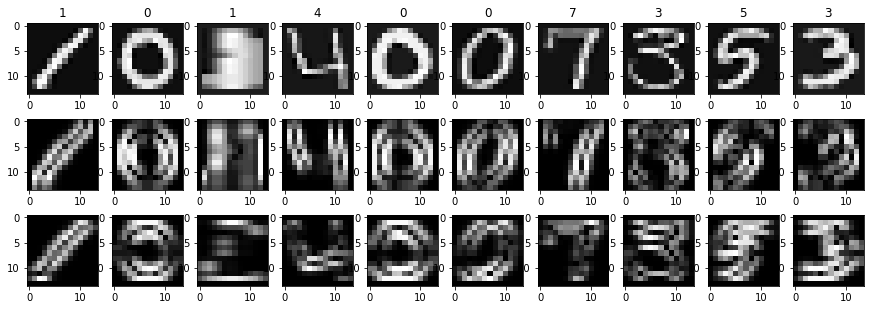

In [151]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i, img in enumerate(train_img):
    train_sobel_x[i] = cv2.Sobel(img, cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=3)

fig = plt.figure(figsize=(15, 5))
for i, img in enumerate(train_img[:10], 1):
    subplot = fig.add_subplot(3, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('{}'.format(int(train_label[i-1])))
    subplot = fig.add_subplot(3, 10, i+10)
    plt.imshow(np.abs(train_sobel_x[i-1]), cmap='gray')
    subplot = fig.add_subplot(3, 10, i+20)
    plt.imshow(np.abs(train_sobel_y[i-1]), cmap='gray');

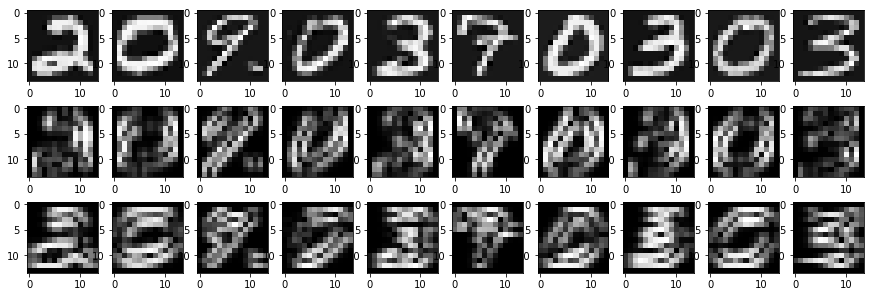

In [152]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i, img in enumerate(test_img):
    test_sobel_x[i] = cv2.Sobel(img, cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=3)
    
fig = plt.figure(figsize=(15, 5))
for i, img in enumerate(test_img[:10], 1):
    subplot = fig.add_subplot(3, 10, i)
    plt.imshow(img, cmap='gray')
    subplot = fig.add_subplot(3, 10, i+10)
    plt.imshow(np.abs(test_sobel_x[i-1]), cmap='gray')
    subplot = fig.add_subplot(3, 10, i+20)
    plt.imshow(np.abs(test_sobel_y[i-1]), cmap='gray');

## Вычисляем угол и длину вектора градиента

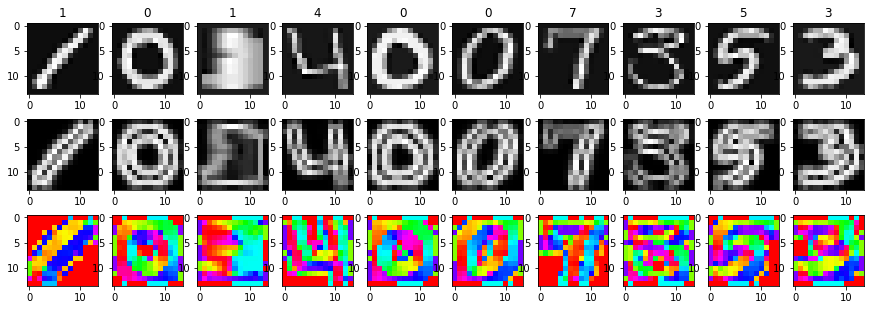

In [153]:
# Вычисляем модуль и направление вектора градиента:
train_grad_norm, train_grad_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
# Приравниваем друг к другу углы, отличающиеся на 180°: 45°=270° и т.п.
# train_grad_theta[train_grad_theta>np.pi] -= np.pi

fig = plt.figure(figsize=(15, 5))
for i, img in enumerate(train_img[:10], 1):
    subplot = fig.add_subplot(3, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('{}'.format(int(train_label[i-1])))
    subplot = fig.add_subplot(3, 10, i+10)
    plt.imshow(np.abs(train_grad_norm[i-1]), cmap='gray')
    subplot = fig.add_subplot(3, 10, i+20)
    plt.imshow(train_grad_theta[i-1], cmap='hsv');

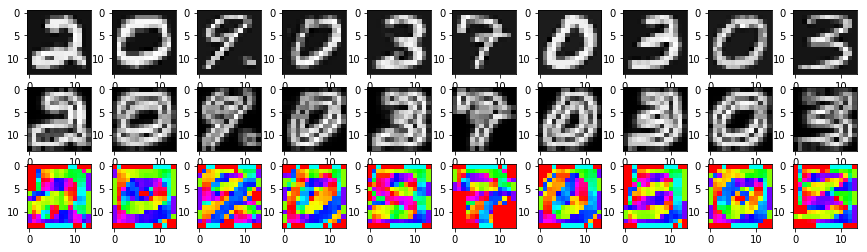

In [154]:
# Вычисляем модуль и направление вектора градиента:
test_grad_norm,  test_grad_theta  = cv2.cartToPolar(test_sobel_x, test_sobel_y)
# Приравниваем друг к другу углы, отличающиеся на 180°: 45°=270° и т.п.
# test_grad_theta[test_grad_theta>np.pi] -= np.pi

fig = plt.figure(figsize=(15, 4))
for i, img in enumerate(test_img[:10], 1):
    subplot = fig.add_subplot(3, 10, i)
    plt.imshow(img, cmap='gray')
    subplot = fig.add_subplot(3, 10, i+10)
    plt.imshow(np.abs(test_grad_norm[i-1]), cmap='gray')
    subplot = fig.add_subplot(3, 10, i+20)
    plt.imshow(test_grad_theta[i-1], cmap='hsv');

## Вычисляем гистограммы градиентов

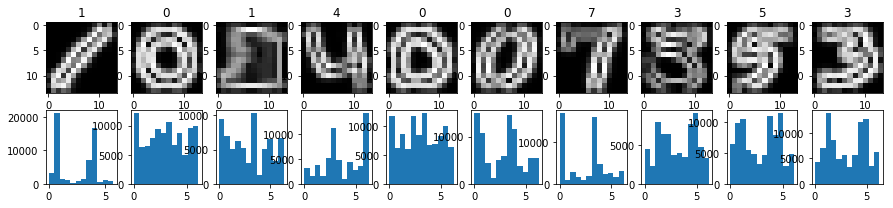

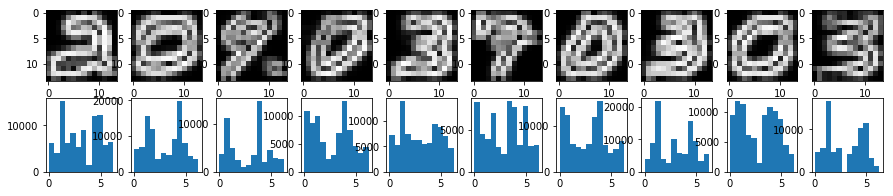

In [155]:
fig = plt.figure(figsize=(15, 3))
for i, img in enumerate(train_grad_norm[:10], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('{}'.format(int(train_label[i-1])))
    subplot = fig.add_subplot(2, 10, i+10)
    plt.hist(train_grad_theta[i - 1].flatten(),
             bins=N_bins, weights=train_grad_norm[i - 1].flatten())
plt.show()
fig = plt.figure(figsize=(15, 3))
for i, img in enumerate(test_grad_norm[:10], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot = fig.add_subplot(2, 10, i+10)
    plt.hist(test_grad_theta[i - 1].flatten(),
             bins=N_bins, weights=test_grad_norm[i - 1].flatten())

In [156]:
# Гистограммы вычисляются с учетом длины вектора градиента и указанной разбивки по областям
def calculate_HOG(grad_norm, grad_theta, grid, bins):
    # Выделяем память под общий вектор ответа
    result = np.zeros((len(grad_norm), grid[0]*grid[1]*bins))
    for i in range(len(grad_norm)):
        for Y_piece in range(grid[1]):
            for X_piece in range(grid[0]):
                # Вычисляем координаты вырезаемой области изображения
                cut = ( Y_piece   *(grad_theta[i].shape[0]//grid[1]),
                       (Y_piece+1)*(grad_theta[i].shape[0]//grid[1]),
                        X_piece   *(grad_theta[i].shape[1]//grid[0]),
                       (X_piece+1)*(grad_theta[i].shape[1]//grid[0]))
                # Рассчитываем гистограмму текущей области с учетом длины вектора градиента
                hist, borders = np.histogram(grad_theta[i][cut[0]:cut[1], cut[2]:cut[3]],
                                             bins=bins,
                                             range=(0., 2*np.pi),
                                             weights=grad_norm[i][cut[0]:cut[1], cut[2]:cut[3]])
                # Нормируем полученную гистограмму области
                hist_norm = np.linalg.norm(hist)
                if hist_norm != 0:
                    hist /= hist_norm
                else:
                    hist *= 0
                # Встраеваем гистограммы по порядку в общий вектор ответа
                result[i][N_bins*(X_piece + grid[0]*Y_piece):N_bins*(X_piece + grid[0]*Y_piece + 1)] = hist
    return result

train_hist = calculate_HOG(train_grad_norm, train_grad_theta, division_shape, N_bins)
test_hist = calculate_HOG(test_grad_norm, test_grad_theta, division_shape, N_bins)

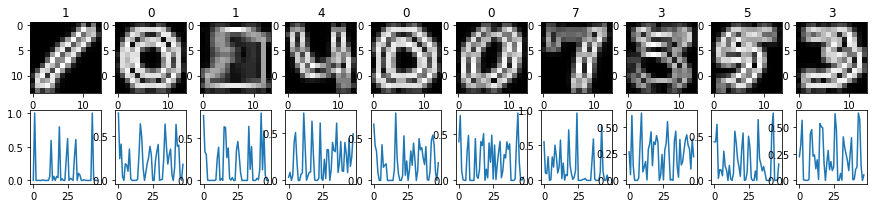

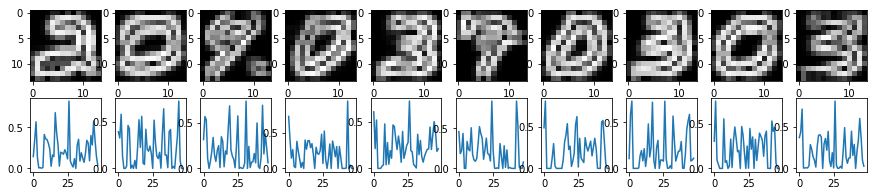

In [157]:
fig = plt.figure(figsize=(15, 3))
for i, img in enumerate(train_grad_norm[:10], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('{}'.format(int(train_label[i-1])))
    subplot = fig.add_subplot(2, 10, i+10)
    plt.plot(train_hist[i-1])
plt.show()
fig = plt.figure(figsize=(15, 3))
for i, img in enumerate(test_grad_norm[:10], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot = fig.add_subplot(2, 10, i+10)
    plt.plot(test_hist[i-1])

## Проводим кросс-валидацию, выбираем алгоритм

In [158]:
# from xgboost import XGBClassifier

# algo = XGBClassifier(max_depth = 7, 
#                      n_estimators = small_img_size*small_img_size + N_bins,
#                      class_weight='balanced')

# cv_gb = cross_val_score(algo,
#                         np.concatenate((train, train_hist), axis=1),
#                         train_label,
#                         scoring='accuracy', cv=5, n_jobs=-1)
# array([0.9323022 , 0.93157206, 0.92796762, 0.93271406, 0.93854216]) - картинка
# array([0.93432481, 0.93430918, 0.9339207 , 0.93307134, 0.93818485]) - картинка + гистограммы
# array([0.9502677 , 0.94525765, 0.9510656 , 0.94974396, 0.95247737]) - 10х10 + гистограммы
# array([0.95930993, 0.953469  , 0.95880462, 0.957723  , 0.95855169]) - 10х10 + гистограммы, глубина 5
# array([0.96323617, 0.95703915, 0.96201929, 0.96153388, 0.96200572]) - 10х10 + гистограммы, глубина 6
# array([0.96811422, 0.96322742, 0.96785332, 0.96653567, 0.96641258]) - 10х10 + гистограммы, глубина 6, много деревьев
# array([0.96859012, 0.96429846, 0.96832956, 0.96594022, 0.96748452]) - 10х10 + гистограммы, глубина 7, много деревьев
# array([0.96859012, 0.9651315 , 0.96868675, 0.96653567, 0.96796093]) - 10х10 + гистограммы, глубина 7, много деревьев и еще +25шт
# array([0.96954194, 0.96572653, 0.96737707, 0.96605931, 0.96760362]) - 10х10 + HOG 2х2, глубина 7, много деревьев
# array([0.97346817, 0.96786862, 0.96880581, 0.96998928, 0.96843735]) - 10х10 + HOG 3х3, глубина 7, много деревьев
# array([0.96918501, 0.96560752, 0.96856769, 0.96629749, 0.96653168]) - 10х10 + HOG 4х4x36, глубина 7, много деревьев
# array([0.96966092, 0.96560752, 0.96928206, 0.96879838, 0.96808004]) - 10х10 + HOG 4х4x72, глубина 7, много деревьев
# array([0.97894111, 0.97786505, 0.97821169, 0.97642015, 0.97856122]) - 14х14 + HOG 2х2x36, глубина 7, много деревьев
# array([0.97644259, 0.97524694, 0.97594952, 0.97415744, 0.97844212]) - 14х14 + HOG 2х2, глубина 7, много деревьев
# array([0.97787032, 0.97774604, 0.97892606, 0.97725378, 0.98046689]) - 14х14 + HOG 2х2x12, глубина 7, много деревьев
# array([0.9800119 , 0.98072117, 0.98142636, 0.97987376, 0.98141972]) - 14x14 + HOG 3х3x12, глубина 7, много деревьев
# array([0.9815586 , 0.98084018, 0.98142636, 0.98046922, 0.98272987]) - 14x14 + HOG 4х4x12, глубина 7, много деревьев
# array([0.98143962, 0.97965012, 0.97833075, 0.97904013, 0.97939495]) - 20х20 + HOG 2х2, глубина 7, много деревьев
cv_gb

array([0.9815586 , 0.98084018, 0.98142636, 0.98046922, 0.98272987])

In [159]:
# algo = LogisticRegression( C = 2,
#                            class_weight = 'balanced',
#                            solver = 'newton-cg',
#                            multi_class = 'multinomial',
#                            max_iter = 100)

# cv_logit = cross_val_score(algo,
#                            np.concatenate((train, train_hist), axis=1),
#                            train_label,
#                            scoring='accuracy', cv=5, n_jobs=-1)
# cv_logit
# array([0.93706127, 0.93276211, 0.93654006, 0.93890675, 0.94020962])

In [ ]:
# from sklearn.svm import LinearSVC
# algo = LinearSVC(dual=False, class_weight='balanced', )

# cv_lsvc = cross_val_score(algo,
#                           np.concatenate((train, train_hist), axis=1),
#                           train_label,
#                           scoring='accuracy', cv=5, n_jobs=-1)
# cv_lsvc
# array([0.92623438, 0.92371772, 0.92796762, 0.92580684, 0.92758456])

## Разбиваем выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.concatenate((train, train_hist), axis=1), train_label,
                                                  test_size=0.1)

## Классифицируем валидационную выборку

In [ ]:
algo_for_validation = algo.fit(x_train, y_train)
pred_val = algo_for_validation.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

## Предсказания на тестовых данных

In [ ]:
algo_battle_edition = algo.fit(np.concatenate((train[:, 1:], train_hist), axis=1),
                               train_label)


In [ ]:
pred_test = algo_battle_edition.predict(np.concatenate((test, test_hist), axis=1)).astype(np.uint8)

## Визуализируем предсказания

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i, img in enumerate(test_img[0:64], 1):
    subplot = fig.add_subplot(8, 8, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('{}'.format(pred_test[i - 1]))
plt.show()

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700